Task:
Analyzing the content of the E-Commerce database that contains the purchases made by approximate ~4000 customers over a period of one year
To develop a model that allows to anticipate or predict the purchases that will be made by a new customer during the following & this year, based on the data available from the previous purchases.


In [3]:
# Importing all the required libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from math import ceil
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble

from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode,iplot
from sklearn.metrics import silhouette_samples, silhouette_score
init_notebook_mode(connected=True)
from sklearn.manifold import TSNE
warnings.filterwarnings("ignore")                                    # Ignoring the warnings
plt.rcParams["patch.force_edgecolor"] = True                         # Setting the default style of Matplotlib
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual,VBox,HBox,Layout
import ipywidgets as widgets




In [4]:
df = pd.read_csv(r"C:\Users\santh\Downloads\Datasets\E-commerce.csv",encoding="ISO-8859-1")


In [5]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['Sales'] = df.Quantity*df.UnitPrice
df['Year']=df.InvoiceDate.dt.year
df['Month']=df.InvoiceDate.dt.month
df['Day']=df.InvoiceDate.dt.day
df['is_cancelled']=df.InvoiceNo.apply(lambda x: 'Yes' if x[0]=='C' else 'No')
df['Date']=pd.to_datetime(df[['Year','Month','Day']])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Month,Day,is_cancelled,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,1,No,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,No,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,1,No,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,No,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,No,2010-12-01


CustomerID and Description is missing.Since it represents 25% of the data This would affect in finding Potential customers

<BarContainer object of 2 artists>

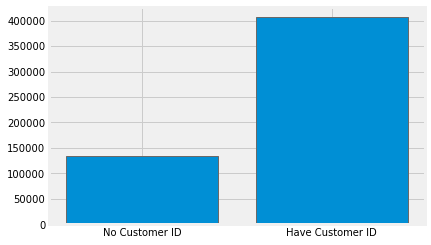

In [17]:
import matplotlib.pyplot as plt

no_customer_id = len(df[df['CustomerID'].isnull()].index)
have_customer_id = len(df[~df['CustomerID'].isnull()].index)

plt.bar(['No Customer ID','Have Customer ID'],[no_customer_id, have_customer_id])
